In [1]:
import talib
from pandas import DataFrame, read_csv, concat, merge, to_datetime
from keras.models import Sequential, model_from_json
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping,Callback
from keras import backend, losses
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from sklearn.feature_selection import mutual_info_regression
from scipy.fft import fft
import emd

In [3]:
data = read_csv('btc_hourly.csv', parse_dates = ['timestamp'], usecols = ['timestamp', 'c']).fillna(method='ffill')
start_time = '2017-01-01 00:00:00'
split_time = '2021-02-01 00:00:00'
end_time = '2021-09-01 00:00:00'
data = data[(data['timestamp'] >= start_time) & (data['timestamp'] < end_time)]
start_index = data.index[data['timestamp'] == start_time].tolist()[0]
split_index = data.index[data['timestamp'] == split_time].tolist()[0]

In [2]:
def get_emd(signal):
    imfs = emd.sift.sift(signal.values)
    
    t = [i for i in range(len(signal))]
    N = imfs.shape[1]
    fig, axs = plt.subplots(N + 1, 1, figsize=(15,9))
    axs[0].plot(t, signal)
    axs[0].text(imfs.shape[0]/2,max(signal)-max(signal)/5,'Original Signal')
    for n in range(N):
        axs[n+1].plot(t, imfs[:,n])
        axs[n+1].text(imfs.shape[0]/2,max(imfs[:,n])-max(imfs[:,n])/5,f'IMF {n+1}')
    
    return imfs

def phase_spectrum(imfs):
    imfs_p = []
    N = imfs.shape[1]
    fig, axs = plt.subplots(N, 1, figsize=(15,9))
    for i in range(N):
        trans = fft(imfs[:,i])
        imf_p = np.arctan(trans.imag / trans.real)
        
        imfs_p.append(imf_p)
        
        axs[i].plot(imf_p, 'o')
        axs[i].set_title(f'IMF {i}')
        
    return imfs_p

def phase_mi(phases):
    mis = []
    for i in range(len(phases)-1):
        mis.append(mutual_info_regression(phases[i].reshape(-1, 1), phases[i+1])[0])
    print(mis)
    return np.array(mis)

def divide_signal(signal, imfs, mis, cutoff=0.05):
    cut_point = np.where(mis > cutoff)[0][0]
    stochastic_component = np.sum(imfs[:,:cut_point], axis=1)
    deterministic_component = np.sum(imfs[:,cut_point:], axis=1)
    
    t = [i for i in range(len(signal))]
    
    fig, axs = plt.subplots(3, 1, figsize=(15,9))
    axs[0].plot(t, signal.values)
    axs[0].set_title('Original Signal')
    
    axs[1].plot(t, stochastic_component)
    axs[1].set_title('Stochastic Component')
    
    axs[2].plot(t, deterministic_component)
    axs[2].set_title('Deterministic Component')
    
    return stochastic_component, deterministic_component

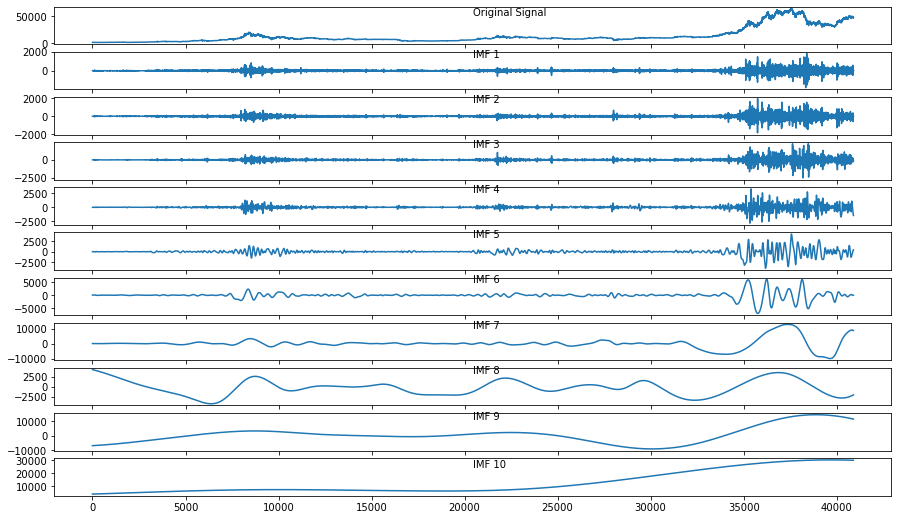

In [4]:
imfs = get_emd(data['c'])

[0.0008826654891356256, 0.003115106423010161, 0.5278796418980978, 4.7469971269873925, 6.541207577682249, 7.670389285959009, 8.980689055531101, 9.03396983296226, 9.073575632772076]


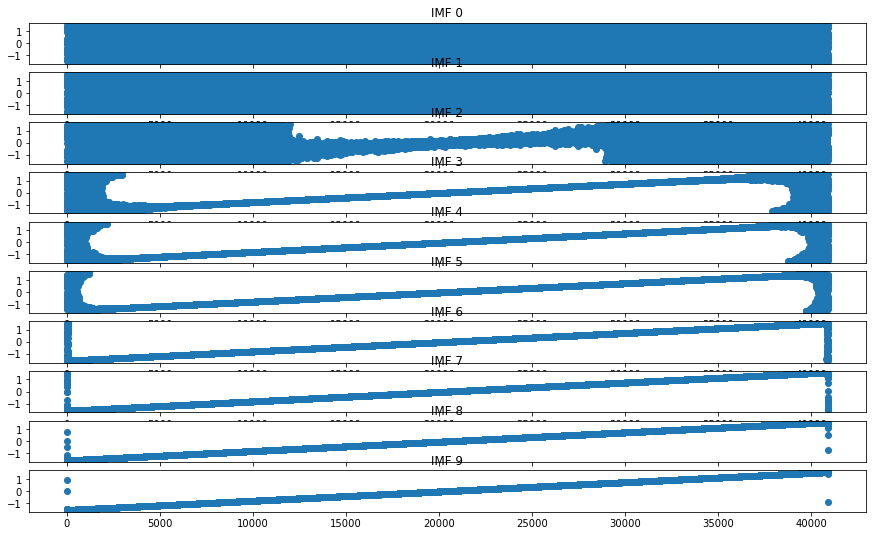

In [6]:
mis = phase_mi(phase_spectrum(imfs))

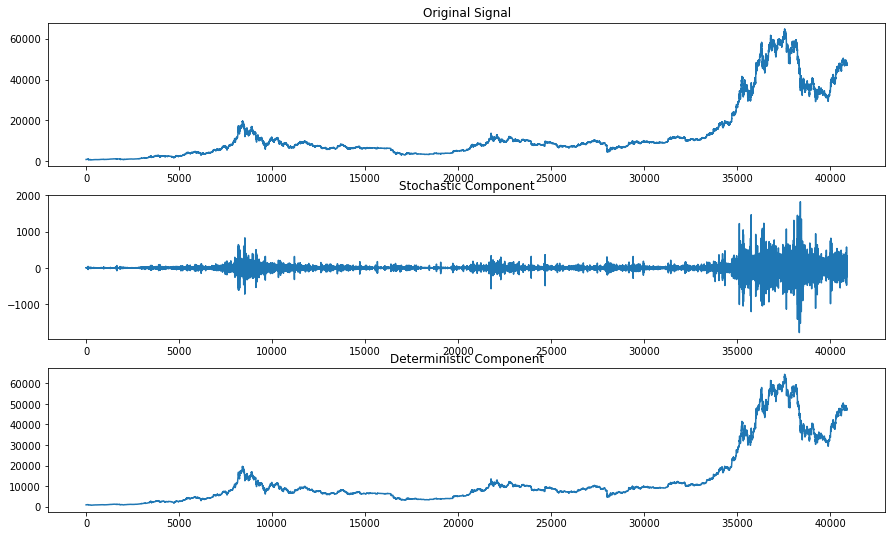

In [7]:
data['d'] = divide_signal(data['c'], imfs, mis, 0.001)[1]

In [8]:
sma_24 = talib.SMA(data['d'], timeperiod=24)
sma_42 = talib.SMA(data['d'], timeperiod=42)
sma_72 = talib.SMA(data['d'], timeperiod=72)
sma_125 = talib.SMA(data['d'], timeperiod=125)
ema_36 = talib.EMA(data['d'], timeperiod=36)
ema_95 = talib.EMA(data['d'], timeperiod=95)
ema_184 = talib.EMA(data['d'], timeperiod=184)
macd = talib.MACD(data['d'], signalperiod=24)[0]
mom = talib.MOM(data['d'], timeperiod=24)
rsi = talib.RSI(data['d'], timeperiod=24)
price = data['d']
label = data['c']

features = DataFrame()
features['sma_24'] = sma_24
features['sma_42'] = sma_42
features['sma_72'] = sma_72
features['sma_125'] = sma_125
features['ema_36'] = ema_36
features['ema_95'] = ema_95
features['ema_184'] = ema_184
features['macd'] = macd
features['rsi'] = rsi
features['mom'] = mom
features['price'] = price
features['label'] = label
#features['y'] = features['label'].diff()
features = features.dropna()
labels = features['label'].values
prices = features['price'].values
#features = features.drop(columns=['label'])

In [9]:
class EarlyStoppingByLossVal(Callback):
    def __init__(self, monitor='val_mape', value=0.01, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)        
            
        if epoch>5:
            if current < self.value:                
                self.model.stop_training = True

In [133]:
def to_supervised(data, n_input, n_out=1):
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input + 1
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end <= len(data):
			x_input = data[in_start:in_end, :]
			X.append(x_input)
			y.append(data[in_end:out_end, -1])
		# move along one time step
		in_start += 1
	return np.array(X), np.array(y)

In [10]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [12]:
scaler = StandardScaler()
scaled = scaler.fit(features).transform(features)

In [13]:
n = 1
series = series_to_supervised(scaled, n, 2)
dropColumns = []
for i in range(scaled.shape[1]-1):
    dropColumns.append('var{}(t+{})'.format(i+1,1))
for i in range(n):
    dropColumns.append('var{}(t-{})'.format(scaled.shape[1],i+1))
dropColumns.append('var{}(t)'.format(scaled.shape[1]))
reframed = series.drop(columns=dropColumns)
#reframed = series

split = int(0.7*scaled.shape[0])
#split = split_index-start_index-timerange-n
train_X, test_X = reframed.values[:split,:-1], reframed.values[split:,:-1]
train_y, test_y = reframed.values[:split,-1], reframed.values[split:,-1]
#Reshaping input to be 3 dimensions (samples, timesteps, features)
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [819]:
reframed

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),...,var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var9(t),var10(t),var11(t),var12(t+1)
1,-0.852338,-0.853870,-0.852120,-0.847495,-0.852552,-0.851008,-0.848020,0.001074,0.022698,0.000527,...,-0.852175,-0.847551,-0.852522,-0.851033,-0.848071,-0.002748,-0.033026,-0.002505,-0.851935,-0.852768
2,-0.852262,-0.853813,-0.852175,-0.847551,-0.852522,-0.851033,-0.848071,-0.002748,-0.033026,-0.002505,...,-0.852227,-0.847608,-0.852503,-0.851061,-0.848122,-0.007099,-0.094564,-0.005307,-0.852091,-0.852777
3,-0.852193,-0.853747,-0.852227,-0.847608,-0.852503,-0.851061,-0.848122,-0.007099,-0.094564,-0.005307,...,-0.852281,-0.847667,-0.852494,-0.851093,-0.848175,-0.011907,-0.160889,-0.008321,-0.852262,-0.852616
4,-0.852131,-0.853671,-0.852281,-0.847667,-0.852494,-0.851093,-0.848175,-0.011907,-0.160889,-0.008321,...,-0.852342,-0.847728,-0.852495,-0.851127,-0.848229,-0.017087,-0.230035,-0.011850,-0.852446,-0.852330
5,-0.852078,-0.853584,-0.852342,-0.847728,-0.852495,-0.851127,-0.848229,-0.017087,-0.230035,-0.011850,...,-0.852410,-0.847790,-0.852507,-0.851165,-0.848285,-0.022546,-0.299949,-0.016185,-0.852638,-0.852132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40707,2.500770,2.516219,2.547328,2.550302,2.511831,2.542963,2.561742,-0.827289,-1.633489,-0.750145,...,2.545640,2.550534,2.509630,2.541679,2.561045,-0.903145,-1.676647,-0.826496,2.465289,2.472326
40708,2.498842,2.513870,2.545640,2.550534,2.509630,2.541679,2.561045,-0.903145,-1.676647,-0.826496,...,2.543860,2.550716,2.507311,2.540331,2.560307,-0.978167,-1.708599,-0.882035,2.460927,2.451138
40709,2.496780,2.511559,2.543860,2.550716,2.507311,2.540331,2.560307,-0.978167,-1.708599,-0.882035,...,2.542004,2.550845,2.504938,2.538941,2.559542,-1.045708,-1.731089,-0.915081,2.457591,2.447078
40710,2.494637,2.509320,2.542004,2.550845,2.504938,2.538941,2.559542,-1.045708,-1.731089,-0.915081,...,2.540095,2.550926,2.502573,2.537535,2.558760,-1.099950,-1.745188,-0.925065,2.455400,2.457570


In [228]:
len(test_y)/(len(train_y)+len(test_y))

0.29996806759843775

In [14]:
model = Sequential()
model.add(LSTM(4, return_sequences=True, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(4, activation='relu'))
model.add(Dense(1))
backend.set_epsilon(1)
model.compile(loss='mse', optimizer='adam', metrics=['mse'])
callbacks = [EarlyStoppingByLossVal(monitor='val_mse', value=0.1, verbose=2)]
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 4)              432       
_________________________________________________________________
lstm_1 (LSTM)                (None, 4)                 144       
_________________________________________________________________
dense (Dense)                (None, 1)                 5         
Total params: 581
Trainable params: 581
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(train_X, train_y, epochs = 100, validation_data=(test_X, test_y), verbose = 2, shuffle = False, callbacks=  callbacks)

In [831]:
#Prediciting exact price values
predictedValues = model.predict(test_X)
trainingValues = model.predict(train_X)
actualValues = np.array(features['label'][n+1:]).reshape(-1,1)
scalerCrypto = scaler.fit(actualValues)
predictedValues = scalerCrypto.inverse_transform(predictedValues)
trainingValues = scalerCrypto.inverse_transform(trainingValues)
actualValues = labels[n+1:]
trainingValues = np.reshape(trainingValues, trainingValues.shape[0])
predictedValues = np.reshape(predictedValues, predictedValues.shape[0])

In [806]:
#predicting returns
predictedValues = model.predict(test_X)
trainingValues = model.predict(train_X)
actualValues = np.array(features['y'][n+1:]).reshape(-1,1)
scalerCrypto = scaler.fit(actualValues)
predictedValues = scalerCrypto.inverse_transform(predictedValues)
trainingValues = scalerCrypto.inverse_transform(trainingValues)
actualValues = labels[n+1:]
trainingValues = np.add(np.reshape(trainingValues, trainingValues.shape[0]), prices[n:-1][:len(trainingValues)])
predictedValues = np.add(np.reshape(predictedValues, predictedValues.shape[0]), prices[n:-1][len(trainingValues):])

In [52]:
def mape(actual, predicted):
    num = 0
    count = 0
    for a, p in zip(actual, predicted):
        num += abs(a-p)/a
        count += 1
    return (num*100)/count

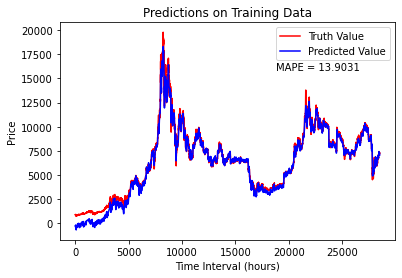

In [832]:
plt.plot(actualValues[:len(trainingValues)], color = 'red', label = 'Truth Value')
plt.plot(trainingValues, color = 'blue', label = 'Predicted Value')
plt.text(18800,15900,'MAPE = '+str(round(mape(actualValues[:len(trainingValues)], trainingValues),4)))
plt.title('Predictions on Training Data')
plt.xlabel('Time Interval (hours)')
plt.ylabel('Price')
plt.legend()
plt.show()

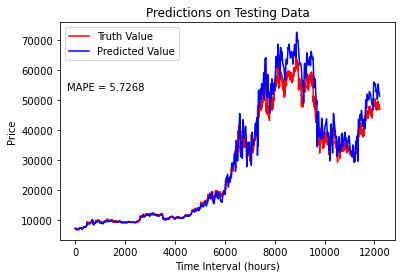

In [833]:
plt.plot(actualValues[-len(predictedValues):], color = 'red', label = 'Truth Value')
plt.plot(predictedValues, color = 'blue', label = 'Predicted Value')
plt.text(-350,53500,'MAPE = '+str(round(mape(actualValues[-len(predictedValues):], predictedValues),4)))
plt.title('Predictions on Testing Data')
plt.xlabel('Time Interval (hours)')
plt.ylabel('Price')
plt.legend()
plt.show()

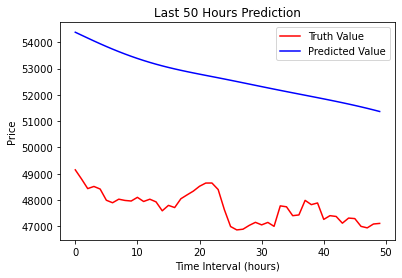

In [834]:
frm=-50
plt.plot(actualValues[frm:], color = 'red', label = 'Truth Value')
plt.plot(predictedValues[frm:], color = 'blue', label = 'Predicted Value') 
plt.title('Last {} Hours Prediction'.format(-frm))
plt.xlabel('Time Interval (hours)')
plt.ylabel('Price')
plt.legend()
plt.show()

In [835]:
actual = [actualValues[:len(trainingValues)], actualValues[-len(predictedValues):]]
predicted = [trainingValues, predictedValues]

for actual1, predicted1 in zip(actual, predicted):
    actual_delta= []
    predicted_delta = []
    correct_long = 0
    incorrect_long = 0
    correct_short = 0
    incorrect_short = 0

    for i in range(len(actual1) - 1):
        a_delta1 = (actual1[i + 1] - actual1[i]) / actual1[i + 1]
        p_delta1 = (predicted1[i + 1] - predicted1[i]) / predicted1[i + 1]

        if p_delta1 > 0 and a_delta1 > 0:
            correct_long += 1

        if p_delta1 > 0 > a_delta1:
            incorrect_long += 1

        if p_delta1 < 0 and a_delta1 < 0:
            correct_short += 1

        if p_delta1 < 0 < a_delta1:
            incorrect_short += 1

    long_p=correct_long/(correct_long+incorrect_long)*100
    short_p=correct_short/(correct_short+incorrect_short)*100
    total_correct= (correct_long+correct_short)/(correct_long+incorrect_long+correct_short+incorrect_short)*100
    print('long =', round(long_p,4))
    print('short =', round(short_p,4))
    print('total =', round(total_correct,4))
    print()

long = 56.021
short = 53.6527
total = 54.9847

long = 53.9685
short = 50.562
total = 52.3532

